In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.inspection import permutation_importance
import xgboost as xgb
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# =============================================================================
# LOAD DATA AND SPLIT
# =============================================================================
df = pd.read_csv('men_2026_matchups_training.csv')

metadata_cols = ['Unnamed: 0', 'game_id', 'year', 'region', 'round',
                 'high_bracket_team', 'low_bracket_team',
                 'high_bracket_seed', 'low_bracket_seed', 'seed']
target_col = 'win'
feature_cols = [col for col in df.columns if col not in metadata_cols + [target_col]]

# Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,
                                      stratify=df[target_col])

X_train = train_df[feature_cols].fillna(0)
y_train = train_df[target_col]
X_test = test_df[feature_cols].fillna(0)
y_test = test_df[target_col]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Features: {len(feature_cols)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols,
                                  index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols,
                                 index=X_test.index)

print("\n" + "="*80)
print("IMPORTANT: All analysis below uses TRAIN SET ONLY to avoid data leakage")
print("="*80)

Train: (1003, 108), Test: (251, 108)
Features: 108

IMPORTANT: All analysis below uses TRAIN SET ONLY to avoid data leakage


In [122]:
# =============================================================================
# BASIC EXPLORATION - TRAIN SET ONLY
# =============================================================================

# Look at training data
print("\nTrain data head:")
# train_df.head()

# Summary stats - TRAIN ONLY
print("\nTrain set summary statistics:")
# X_train.describe()

# Check target distribution - TRAIN ONLY
print(f"\nTrain target distribution:")
print(y_train.value_counts())

# Missing values - TRAIN ONLY
print(f"\nMissing values in train set: {X_train.isnull().sum().sum()}")




Train data head:

Train set summary statistics:

Train target distribution:
win
1    502
0    501
Name: count, dtype: int64

Missing values in train set: 0


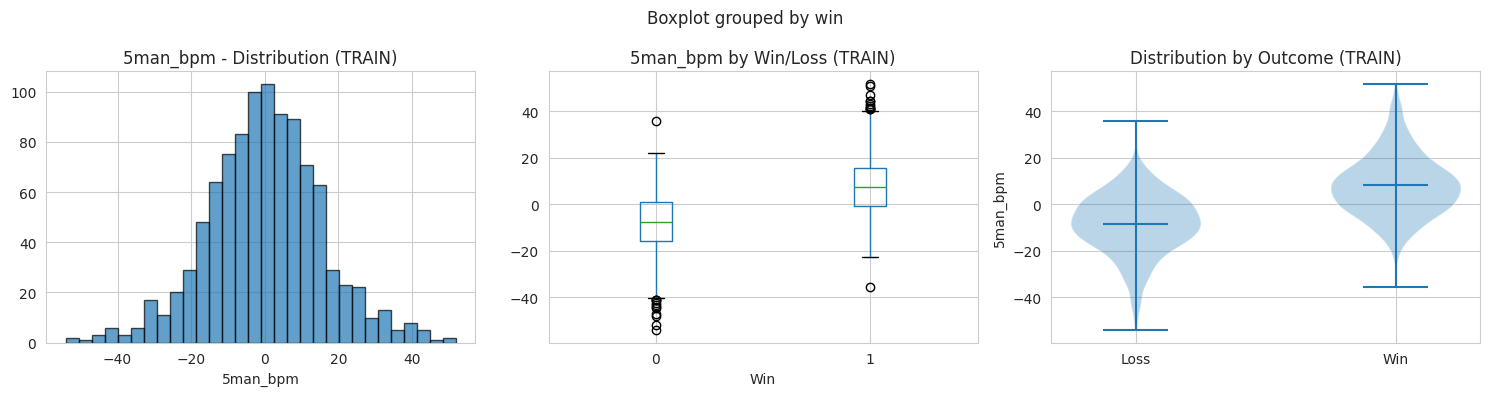


5man_bpm Statistics (TRAIN SET):
Mean (Loss): -8.3992
Mean (Win): 8.3295
Std (Loss): 13.1380
Std (Win): 13.2974

T-test: t=20.0408, p=2.2063e-75
Correlation with win: r=0.5351, p=2.2063e-75


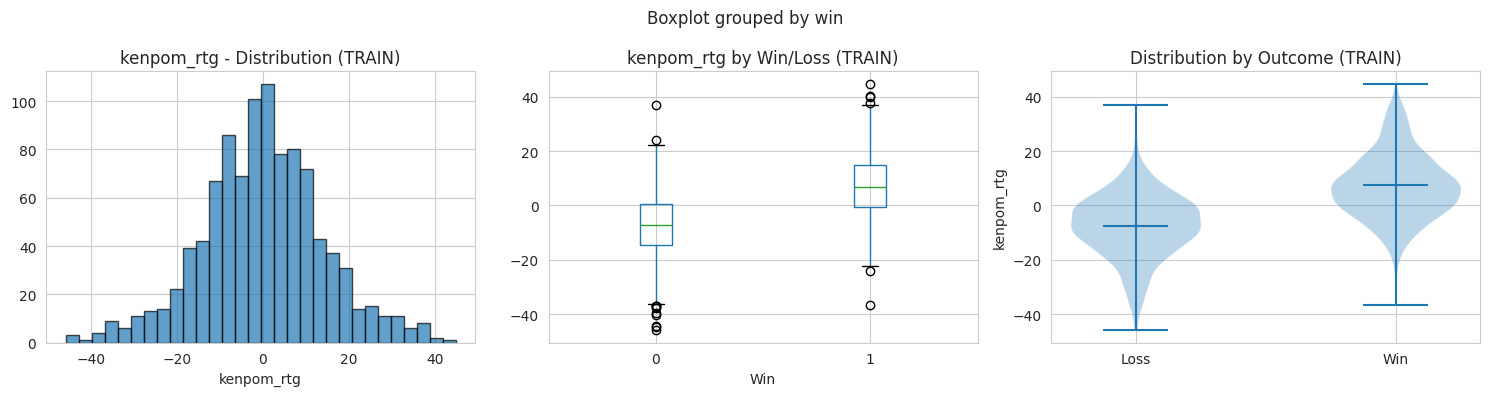


kenpom_rtg Statistics (TRAIN SET):
Mean (Loss): -7.5440
Mean (Win): 7.3910
Std (Loss): 11.9672
Std (Win): 12.1955

T-test: t=19.5743, p=1.7146e-72
Correlation with win: r=0.5261, p=1.7146e-72


In [123]:
# =============================================================================
# UNIVARIATE ANALYSIS - TRAIN SET ONLY
# =============================================================================

def explore_feature(feature_name):
    """
    Examine a single feature - TRAIN SET ONLY
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Histogram
    axes[0].hist(train_df[feature_name].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'{feature_name} - Distribution (TRAIN)')
    axes[0].set_xlabel(feature_name)

    # Box plot by win/loss
    train_df.boxplot(column=feature_name, by=target_col, ax=axes[1])
    axes[1].set_title(f'{feature_name} by Win/Loss (TRAIN)')
    axes[1].set_xlabel('Win')

    # Violin plot
    wins = train_df[train_df[target_col] == 1][feature_name].dropna()
    losses = train_df[train_df[target_col] == 0][feature_name].dropna()
    axes[2].violinplot([losses, wins], positions=[0, 1], showmeans=True)
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(['Loss', 'Win'])
    axes[2].set_ylabel(feature_name)
    axes[2].set_title('Distribution by Outcome (TRAIN)')

    plt.tight_layout()
    plt.show()

    # Stats
    print(f"\n{feature_name} Statistics (TRAIN SET):")
    print(f"Mean (Loss): {losses.mean():.4f}")
    print(f"Mean (Win): {wins.mean():.4f}")
    print(f"Std (Loss): {losses.std():.4f}")
    print(f"Std (Win): {wins.std():.4f}")

    # T-test
    t_stat, p_val = stats.ttest_ind(wins, losses)
    print(f"\nT-test: t={t_stat:.4f}, p={p_val:.4e}")

    # Correlation
    corr, p = pointbiserialr(y_train, train_df[feature_name])
    print(f"Correlation with win: r={corr:.4f}, p={p:.4e}")


explore_feature('5man_bpm')
explore_feature('kenpom_rtg')

In [124]:
def get_correlations_with_target():
    """
    Calculate correlation of all features with target - TRAIN SET ONLY
    """
    results = []
    for col in feature_cols:
        corr, p_val = pointbiserialr(y_train, train_df[col])
        results.append({
            'feature': col,
            'correlation': corr,
            'abs_correlation': abs(corr),
            'p_value': p_val
        })

    return pd.DataFrame(results).sort_values('abs_correlation', ascending=False)

corr_df = get_correlations_with_target()
corr_df.head(48)

,feature,correlation,abs_correlation,p_value
0,5man_bpm,0.535110,0.535110,2.206316e-75
3,kenpom_rtg,0.526131,0.526131,1.714615e-72
1,3man_bpm,0.512638,0.512638,2.616721e-68
2,wab,0.500232,0.500232,1.265037e-64
4,torvik_rtg,0.483390,0.483390,7.365243e-60
42,5man_dbpm,0.461238,0.461238,5.534370e-54
25,5man_obpm,0.455560,0.455560,1.517303e-52
45,torvik_def,0.431944,0.431944,7.553978e-47
44,kenpom_def,0.427101,0.427101,9.811717e-46
28,torvik_off,0.424741,0.424741,3.373291e-45


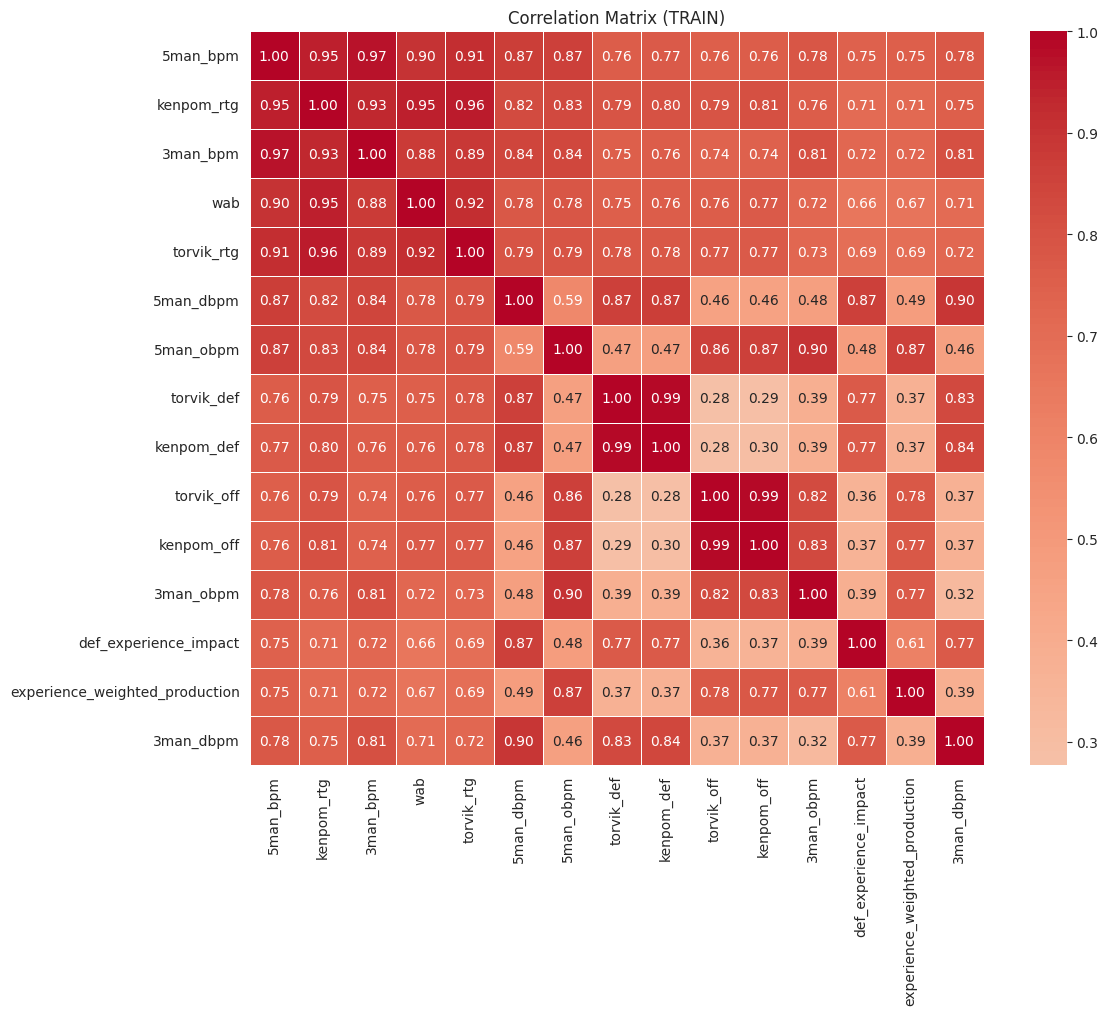

,5man_bpm,kenpom_rtg,3man_bpm,wab,torvik_rtg,5man_dbpm,5man_obpm,torvik_def,kenpom_def,torvik_off,kenpom_off,3man_obpm,def_experience_impact,experience_weighted_production,3man_dbpm
5man_bpm,1.000000,0.951914,0.970282,0.898668,0.913878,0.867380,0.865545,0.764965,0.770369,0.756902,0.761777,0.784412,0.746958,0.748843,0.778931
kenpom_rtg,0.951914,1.000000,0.932157,0.946932,0.959502,0.824604,0.829581,0.790652,0.803649,0.791471,0.805866,0.761127,0.706135,0.713571,0.753805
3man_bpm,0.970282,0.932157,1.000000,0.881160,0.889143,0.841996,0.839406,0.750050,0.757079,0.735653,0.743282,0.809209,0.718428,0.719056,0.805934
wab,0.898668,0.946932,0.881160,1.000000,0.918749,0.775116,0.780351,0.749023,0.757611,0.757075,0.766475,0.719124,0.663114,0.671235,0.709778
torvik_rtg,0.913878,0.959502,0.889143,0.918749,1.000000,0.792601,0.791077,0.777372,0.775808,0.768251,0.768549,0.725479,0.689146,0.690455,0.724649
5man_dbpm,0.867380,0.824604,0.841996,0.775116,0.792601,1.000000,0.586396,0.866090,0.868598,0.456822,0.459655,0.475559,0.865246,0.485039,0.895356
5man_obpm,0.865545,0.829581,0.839406,0.780351,0.791077,0.586396,1.000000,0.466707,0.468868,0.863510,0.865356,0.899297,0.481836,0.866093,0.463478
torvik_def,0.764965,0.790652,0.750050,0.749023,0.777372,0.866090,0.466707,1.000000,0.987762,0.276719,0.286584,0.389365,0.772497,0.372257,0.832588
kenpom_def,0.770369,0.803649,0.757079,0.757611,0.775808,0.868598,0.468868,0.987762,1.000000,0.284664,0.295275,0.391798,0.771657,0.373120,0.840559
torvik_off,0.756902,0.791471,0.735653,0.757075,0.768251,0.456822,0.863510,0.276719,0.284664,1.000000,0.987446,0.824890,0.363227,0.775167,0.369776


In [125]:
def plot_correlation_matrix(features, title="Correlation Matrix (TRAIN)"):
    """
    Plot correlation matrix for selected features - TRAIN SET ONLY
    """
    corr_matrix = train_df[features].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return corr_matrix


top_features = corr_df.head(15)['feature'].tolist()
plot_correlation_matrix(top_features)

In [126]:
def find_high_correlations(threshold=0.8):
    """
    Find pairs of features with correlation above threshold - TRAIN SET ONLY
    """
    corr_matrix = X_train.corr()
    high_corr = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > threshold:
                high_corr.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_val
                })

    return pd.DataFrame(high_corr).sort_values('correlation', key=abs, ascending=False)

high_corr_pairs = find_high_correlations(0.9)
high_corr_pairs

,feature1,feature2,correlation
26,free_throw_advantage,def_free_throw_advantage,-1.000000
14,adj_tempo,tempo_advantage,1.000000
11,bench,bench_scoring_ratio,1.000000
22,net_turnover_margin,def_net_turnover_margin,-1.000000
21,net_efg_margin,def_net_efg_margin,-1.000000
24,net_ftr_margin,def_net_ftr_margin,-1.000000
23,net_rebounding_margin,def_net_rebounding_margin,-1.000000
25,size_speed_index,def_size_speed_index,1.000000
9,height,size_speed_index,0.998449
10,height,def_size_speed_index,0.998449


In [127]:
# =============================================================================
# STATISTICAL TESTS - TRAIN SET ONLY
# =============================================================================

def run_t_tests():
    """
    Run t-tests for all features - TRAIN SET ONLY
    """
    results = []
    for col in feature_cols:
        wins = train_df[train_df[target_col] == 1][col]
        losses = train_df[train_df[target_col] == 0][col]

        t_stat, p_val = stats.ttest_ind(wins, losses)

        results.append({
            'feature': col,
            't_statistic': t_stat,
            'p_value': p_val,
            'mean_difference': wins.mean() - losses.mean()
        })

    return pd.DataFrame(results).sort_values('p_value')

t_test_results = run_t_tests()
t_test_results.head(54)

,feature,t_statistic,p_value,mean_difference
0,5man_bpm,20.040814,2.206316e-75,16.728684
3,kenpom_rtg,19.574269,1.714615e-72,14.935006
1,3man_bpm,18.890105,2.616721e-68,10.162900
2,wab,18.277840,1.265037e-64,7.398451
4,torvik_rtg,17.470513,7.365243e-60,0.211839
42,5man_dbpm,16.446875,5.534370e-54,8.765750
25,5man_obpm,16.190944,1.517303e-52,8.690271
45,torvik_def,15.152536,7.553978e-47,7.748378
44,kenpom_def,14.944509,9.811717e-46,7.513576
28,torvik_off,14.843672,3.373291e-45,7.633724


In [128]:
def run_anova_tests():
    """
    Run ANOVA F-tests - TRAIN SET ONLY
    """
    X_train_filled = X_train.fillna(0)

    f_scores, p_values = f_classif(X_train_filled, y_train)

    results = pd.DataFrame({
        'feature': feature_cols,
        'f_score': f_scores,
        'p_value': p_values
    }).sort_values('f_score', ascending=False)

    return results

anova_results = run_anova_tests()
anova_results.head(48)

,feature,f_score,p_value
0,5man_bpm,401.634217,2.206316e-75
3,kenpom_rtg,383.152013,1.714615e-72
1,3man_bpm,356.836081,2.616721e-68
2,wab,334.079444,1.265037e-64
4,torvik_rtg,305.218823,7.365243e-60
42,5man_dbpm,270.499699,5.534370e-54
25,5man_obpm,262.146653,1.517303e-52
45,torvik_def,229.599355,7.553978e-47
44,kenpom_def,223.338336,9.811717e-46
28,torvik_off,220.334597,3.373291e-45


In [129]:
def calculate_mutual_information():
    """
    Calculate mutual information scores - TRAIN SET ONLY
    """
    X_train_filled = X_train.fillna(0)

    mi_scores = mutual_info_classif(X_train_filled, y_train, random_state=42)

    results = pd.DataFrame({
        'feature': feature_cols,
        'mutual_info': mi_scores
    }).sort_values('mutual_info', ascending=False)

    return results

mi_results = calculate_mutual_information()
mi_results.head(17)

,feature,mutual_info
0,5man_bpm,0.198022
3,kenpom_rtg,0.164330
4,torvik_rtg,0.163273
1,3man_bpm,0.155556
2,wab,0.150340
27,kenpom_off,0.112108
28,torvik_off,0.104266
26,3man_obpm,0.102865
45,torvik_def,0.102089
25,5man_obpm,0.101566


In [130]:
def calculate_effect_sizes():
    """
    Calculate Cohen's d for all features - TRAIN SET ONLY
    """
    results = []
    for col in feature_cols:
        wins = train_df[train_df[target_col] == 1][col].dropna()
        losses = train_df[train_df[target_col] == 0][col].dropna()

        pooled_std = np.sqrt(((len(wins)-1)*wins.var() + (len(losses)-1)*losses.var()) /
                             (len(wins) + len(losses) - 2))

        cohens_d = (wins.mean() - losses.mean()) / pooled_std if pooled_std > 0 else 0

        results.append({
            'feature': col,
            'cohens_d': cohens_d,
            'abs_cohens_d': abs(cohens_d)
        })

    return pd.DataFrame(results).sort_values('abs_cohens_d', ascending=False)

effect_sizes = calculate_effect_sizes()
effect_sizes.head(20)

,feature,cohens_d,abs_cohens_d
0,5man_bpm,1.265596,1.265596
3,kenpom_rtg,1.236133,1.236133
1,3man_bpm,1.192928,1.192928
2,wab,1.154263,1.154263
4,torvik_rtg,1.103279,1.103279
42,5man_dbpm,1.038635,1.038635
25,5man_obpm,1.022473,1.022473
45,torvik_def,0.956897,0.956897
44,kenpom_def,0.943760,0.943760
28,torvik_off,0.937392,0.937392


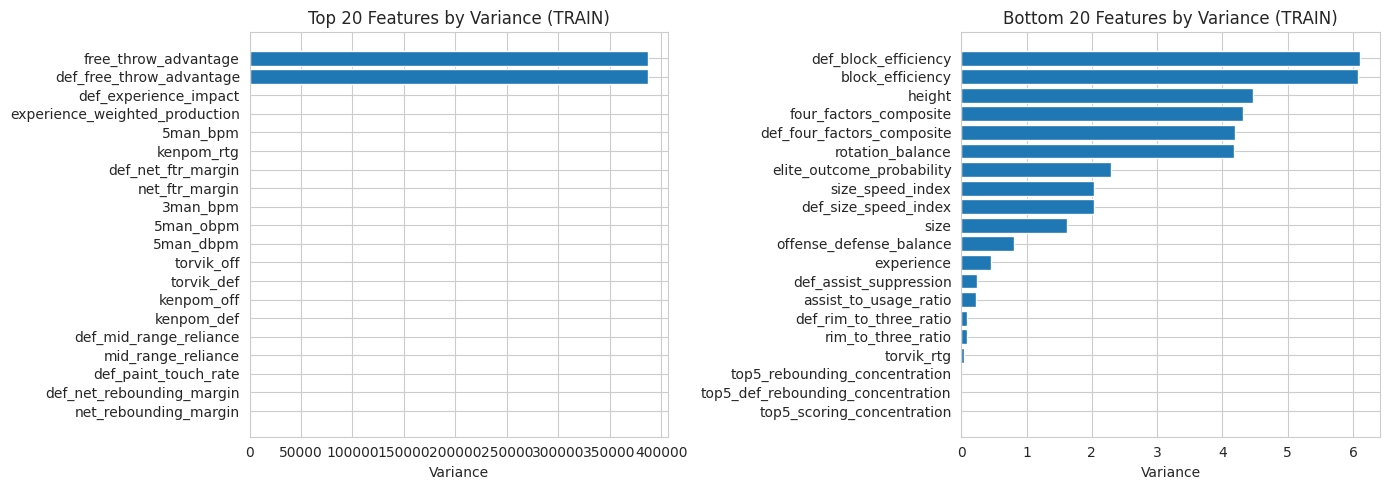

In [131]:
def get_variance_analysis():
    """
    Analyze feature variance - TRAIN SET ONLY
    """
    variances = X_train.var().sort_values(ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Top variances
    axes[0].barh(range(20), variances.head(20).values)
    axes[0].set_yticks(range(20))
    axes[0].set_yticklabels(variances.head(20).index)
    axes[0].set_xlabel('Variance')
    axes[0].set_title('Top 20 Features by Variance (TRAIN)')
    axes[0].invert_yaxis()

    # Bottom variances
    axes[1].barh(range(20), variances.tail(20).values)
    axes[1].set_yticks(range(20))
    axes[1].set_yticklabels(variances.tail(20).index)
    axes[1].set_xlabel('Variance')
    axes[1].set_title('Bottom 20 Features by Variance (TRAIN)')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

    return variances

variance_analysis = get_variance_analysis()

In [132]:
# =============================================================================
# 1. LOGISTIC REGRESSION COEFFICIENTS
# =============================================================================

def logistic_regression_features(C=1.0, penalty='l2'):
    """
    Fit logistic regression and examine coefficients
    """
    lr = LogisticRegression(C=C, penalty=penalty, max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)

    coef_df = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': lr.coef_[0],
        'abs_coefficient': np.abs(lr.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)

    print(f"\nLogistic Regression (C={C}, penalty={penalty})")
    print(f"Train score: {lr.score(X_train_scaled, y_train):.4f}")
    print(f"CV score: {cross_val_score(lr, X_train_scaled, y_train, cv=5).mean():.4f}")

    return coef_df, lr

# Example usage:
coef_df, lr_model = logistic_regression_features(C=1.0, penalty='l2')
coef_df.head(20)


Logistic Regression (C=1.0, penalty=l2)
Train score: 0.7976
CV score: 0.7349


,feature,coefficient,abs_coefficient
28,torvik_off,1.298644,1.298644
4,torvik_rtg,-1.228283,1.228283
45,torvik_def,1.186786,1.186786
48,3pd_pct,-1.150074,1.150074
31,3p_pct,-1.112688,1.112688
58,def_3pt_fg_pct,0.999271,0.999271
0,5man_bpm,0.874604,0.874604
41,off_3pt_fg_pct,0.853798,0.853798
18,off_close2_share,0.789026,0.789026
20,off_3pt_share,-0.782185,0.782185


Alpha=0.0001: 108 features, CV score=0.7369
Alpha=0.001: 106 features, CV score=0.7359
Alpha=0.01: 101 features, CV score=0.7369
Alpha=0.1: 92 features, CV score=0.7349
Alpha=1.0: 64 features, CV score=0.7319


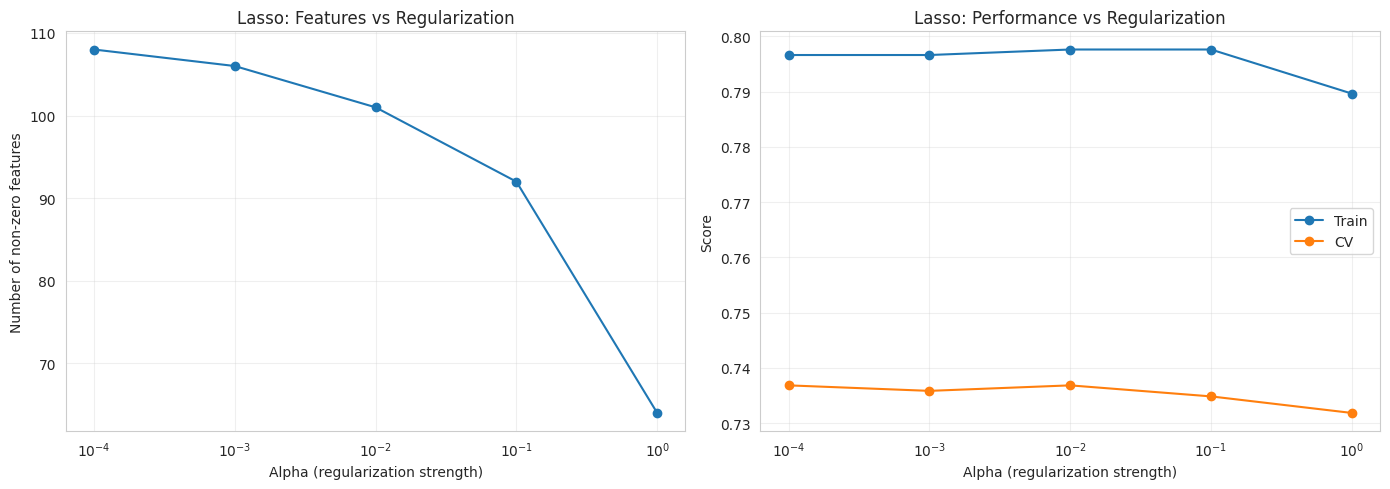

,alpha,n_features,train_score,cv_score
0,0.0001,108,0.796610,0.736851
1,0.0010,106,0.796610,0.735856
2,0.0100,101,0.797607,0.736851
3,0.1000,92,0.797607,0.734856
4,1.0000,64,0.789631,0.731861


In [133]:
# =============================================================================
# 2. LASSO FOR FEATURE SELECTION
# =============================================================================

def lasso_feature_selection(alphas=[0.001, 0.01, 0.1, 1.0]):
    """
    Use Lasso to identify features (L1 regularization drives coefficients to 0)
    """
    results = []

    for alpha in alphas:
        lasso = LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear',
                                    max_iter=1000, random_state=42)
        lasso.fit(X_train_scaled, y_train)

        n_features = np.sum(lasso.coef_[0] != 0)
        train_score = lasso.score(X_train_scaled, y_train)
        cv_score = cross_val_score(lasso, X_train_scaled, y_train, cv=5).mean()

        results.append({
            'alpha': alpha,
            'n_features': n_features,
            'train_score': train_score,
            'cv_score': cv_score
        })

        print(f"Alpha={alpha}: {n_features} features, CV score={cv_score:.4f}")

    results_df = pd.DataFrame(results)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(results_df['alpha'], results_df['n_features'], marker='o')
    axes[0].set_xlabel('Alpha (regularization strength)')
    axes[0].set_ylabel('Number of non-zero features')
    axes[0].set_xscale('log')
    axes[0].set_title('Lasso: Features vs Regularization')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(results_df['alpha'], results_df['train_score'], marker='o', label='Train')
    axes[1].plot(results_df['alpha'], results_df['cv_score'], marker='o', label='CV')
    axes[1].set_xlabel('Alpha (regularization strength)')
    axes[1].set_ylabel('Score')
    axes[1].set_xscale('log')
    axes[1].set_title('Lasso: Performance vs Regularization')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_df

lasso_results = lasso_feature_selection([0.0001, 0.001, 0.01, 0.1, 1.0])
lasso_results

In [134]:
def get_lasso_selected_features(alpha=1.0):
    """
    Get features selected by Lasso at a specific alpha
    """
    lasso = LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear',
                               max_iter=1000, random_state=42)
    lasso.fit(X_train_scaled, y_train)

    selected_features = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': lasso.coef_[0]
    })
    selected_features = selected_features[selected_features['coefficient'] != 0]
    selected_features = selected_features.sort_values('coefficient', key=abs, ascending=False)

    return selected_features, lasso

selected_features, lasso_model = get_lasso_selected_features(alpha=1.0)
selected_features

,feature,coefficient
4,torvik_rtg,-1.274250
28,torvik_off,1.270898
45,torvik_def,1.258588
58,def_3pt_fg_pct,1.253332
41,off_3pt_fg_pct,1.135835
...,...,...
69,paint_touch_rate,-0.016256
51,tord,-0.012927
55,def_dunk_fg_pct,-0.009764
47,2pd_pct,-0.006904


In [135]:
# =============================================================================
# 3. RANDOM FOREST FEATURE IMPORTANCE
# =============================================================================

def random_forest_importance(n_estimators=100, max_depth=None):
    """
    Get feature importance from Random Forest
    """
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nRandom Forest (n_estimators={n_estimators}, max_depth={max_depth})")
    print(f"Train score: {rf.score(X_train, y_train):.4f}")
    print(f"Test score: {rf.score(X_test, y_test):.4f}")
    print(f"CV score: {cross_val_score(rf, X_train, y_train, cv=5).mean():.4f}")

    return importance_df, rf

rf_importance, rf_model = random_forest_importance(n_estimators=100)
rf_importance.head(20)


Random Forest (n_estimators=100, max_depth=None)
Train score: 1.0000
Test score: 0.6733
CV score: 0.7218


,feature,importance
0,5man_bpm,0.055182
1,3man_bpm,0.044051
4,torvik_rtg,0.039044
2,wab,0.038814
3,kenpom_rtg,0.035245
43,3man_dbpm,0.028711
42,5man_dbpm,0.027023
25,5man_obpm,0.021092
45,torvik_def,0.018608
28,torvik_off,0.016382


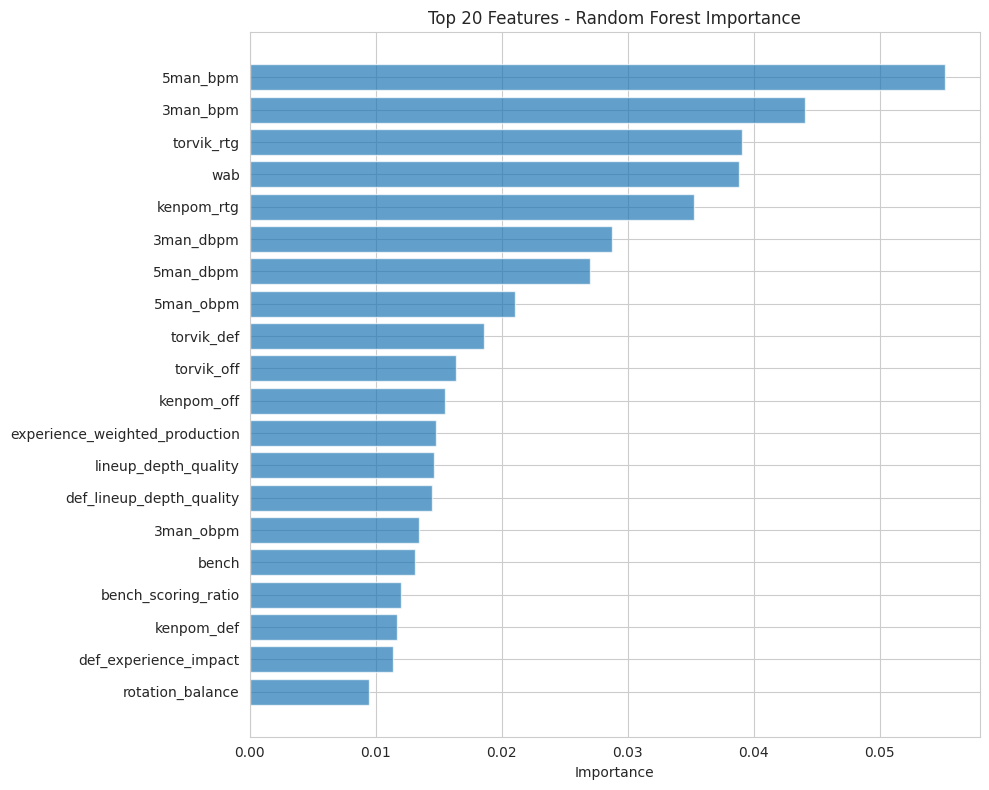

In [136]:
def plot_rf_importance(importance_df, top_n=20):
    """
    Plot Random Forest feature importance
    """
    top_features = importance_df.head(top_n)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance')
    ax.set_title(f'Top {top_n} Features - Random Forest Importance')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_rf_importance(rf_importance, top_n=20)

In [137]:
# =============================================================================
# 4. GRADIENT BOOSTING FEATURE IMPORTANCE
# =============================================================================

def gradient_boosting_importance(n_estimators=100, learning_rate=0.1, max_depth=3):
    """
    Get feature importance from Gradient Boosting
    """
    gb = GradientBoostingClassifier(n_estimators=n_estimators,
                                     learning_rate=learning_rate,
                                     max_depth=max_depth,
                                     random_state=42)
    gb.fit(X_train, y_train)

    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': gb.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nGradient Boosting (n_estimators={n_estimators}, lr={learning_rate})")
    print(f"Train score: {gb.score(X_train, y_train):.4f}")
    print(f"Test score: {gb.score(X_test, y_test):.4f}")
    print(f"CV score: {cross_val_score(gb, X_train, y_train, cv=5).mean():.4f}")

    return importance_df, gb

gb_importance, gb_model = gradient_boosting_importance()
gb_importance.head(20)


Gradient Boosting (n_estimators=100, lr=0.1)
Train score: 0.9462
Test score: 0.6773
CV score: 0.7069


,feature,importance
0,5man_bpm,0.168020
3,kenpom_rtg,0.151756
4,torvik_rtg,0.066591
2,wab,0.038004
43,3man_dbpm,0.031140
12,bench,0.030541
73,bench_scoring_ratio,0.022038
96,def_rim_to_three_ratio,0.021844
26,3man_obpm,0.020367
51,tord,0.016677


In [138]:
# =============================================================================
# 5. PERMUTATION IMPORTANCE
# =============================================================================

def permutation_feature_importance(model, n_repeats=10):
    """
    Calculate permutation importance (more reliable than built-in importance)
    """
    perm_importance = permutation_importance(model, X_train_scaled, y_train,
                                             n_repeats=n_repeats,
                                             random_state=42, n_jobs=-1)

    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)

    return importance_df

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
perm_importance = permutation_feature_importance(lr_model)
perm_importance.head(20)

,feature,importance_mean,importance_std
28,torvik_off,0.143470,0.012911
45,torvik_def,0.130409,0.012363
58,def_3pt_fg_pct,0.084247,0.014675
48,3pd_pct,0.080459,0.008761
31,3p_pct,0.076471,0.010158
0,5man_bpm,0.072981,0.006905
41,off_3pt_fg_pct,0.066899,0.011910
20,off_3pt_share,0.058225,0.007356
67,rim_to_three_ratio,0.054237,0.005731
24,def_3pt_share,0.049252,0.007490


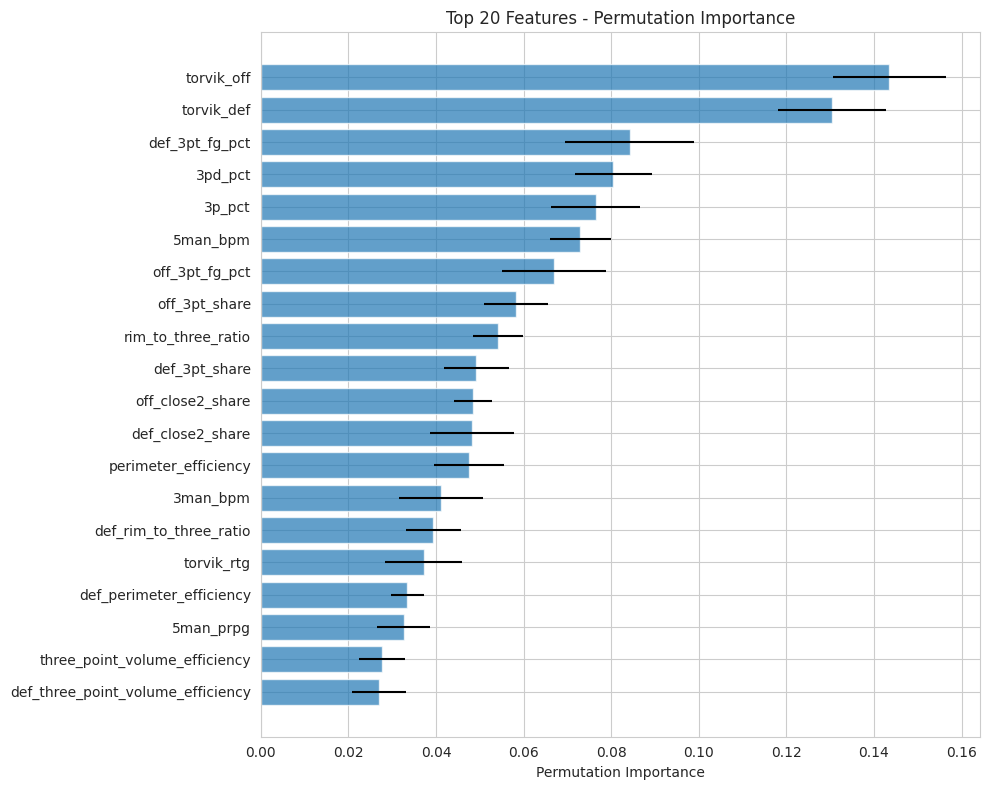

In [139]:

def plot_permutation_importance(importance_df, top_n=20):
    """
    Plot permutation importance with error bars
    """
    top_features = importance_df.head(top_n)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top_features)), top_features['importance_mean'],
            xerr=top_features['importance_std'], alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Permutation Importance')
    ax.set_title(f'Top {top_n} Features - Permutation Importance')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_permutation_importance(perm_importance, top_n=20)

In [140]:

# =============================================================================
# 6. RECURSIVE FEATURE ELIMINATION (RFE)
# =============================================================================

def recursive_feature_elimination(n_features_to_select=20):
    """
    Use RFE to select features
    """
    lr = LogisticRegression(random_state=42, max_iter=1000)
    rfe = RFE(estimator=lr, n_features_to_select=n_features_to_select)
    rfe.fit(X_train_scaled, y_train)

    selected_df = pd.DataFrame({
        'feature': feature_cols,
        'selected': rfe.support_,
        'ranking': rfe.ranking_
    }).sort_values('ranking')

    selected_features = selected_df[selected_df['selected'] == True]

    print(f"\nRFE selected {len(selected_features)} features:")
    print(selected_features['feature'].tolist())

    return selected_df, rfe

rfe_results, rfe_model = recursive_feature_elimination(n_features_to_select=20)
rfe_results


RFE selected 20 features:
['5man_bpm', 'torvik_rtg', 'raw_tempo', 'experience', 'adj_tempo', 'off_3pt_share', 'off_close2_share', 'off_dunk_share', '5man_obpm', 'torvik_off', '3p_pct', 'def_3pt_fg_pct', '3pd_pct', 'off_3pt_fg_pct', 'torvik_def', '5man_dbpm', 'def_experience_impact', 'experience_weighted_production', 'tempo_advantage', 'rim_to_three_ratio']


,feature,selected,ranking
0,5man_bpm,True,1
4,torvik_rtg,True,1
13,raw_tempo,True,1
11,experience,True,1
14,adj_tempo,True,1
...,...,...,...
88,def_net_efg_margin,False,85
15,3pr,False,86
59,net_efg_margin,False,87
6,3man_prpg,False,88


In [141]:
# =============================================================================
# 7. COMPARE MULTIPLE METHODS
# =============================================================================

def compare_feature_selection_methods():
    """
    Compare feature importance across different methods
    """
    # Logistic Regression coefficients
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    lr_importance = pd.DataFrame({
        'feature': feature_cols,
        'lr_coef': np.abs(lr.coef_[0])
    })

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_importance = pd.DataFrame({
        'feature': feature_cols,
        'rf_importance': rf.feature_importances_
    })

    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)
    gb_importance = pd.DataFrame({
        'feature': feature_cols,
        'gb_importance': gb.feature_importances_
    })

    # Merge all
    comparison = lr_importance.merge(rf_importance, on='feature')
    comparison = comparison.merge(gb_importance, on='feature')

    # Normalize to 0-1 scale
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    comparison['lr_coef_norm'] = scaler.fit_transform(comparison[['lr_coef']])
    comparison['rf_importance_norm'] = scaler.fit_transform(comparison[['rf_importance']])
    comparison['gb_importance_norm'] = scaler.fit_transform(comparison[['gb_importance']])

    # Average rank
    comparison['avg_importance'] = (comparison['lr_coef_norm'] +
                                    comparison['rf_importance_norm'] +
                                    comparison['gb_importance_norm']) / 3

    comparison = comparison.sort_values('avg_importance', ascending=False)

    return comparison

comparison = compare_feature_selection_methods()
comparison.head(87)

,feature,lr_coef,rf_importance,gb_importance,lr_coef_norm,rf_importance_norm,gb_importance_norm,avg_importance
0,5man_bpm,0.874604,0.055182,0.168020,0.672505,1.000000,1.000000,0.890835
4,torvik_rtg,1.228283,0.039044,0.066591,0.945659,0.695850,0.396327,0.679279
3,kenpom_rtg,0.065653,0.035245,0.151756,0.047733,0.624254,0.903199,0.525062
28,torvik_off,1.298644,0.016382,0.013831,1.000000,0.268725,0.082315,0.450347
1,3man_bpm,0.598855,0.044051,0.011206,0.459537,0.790226,0.066695,0.438819
...,...,...,...,...,...,...,...,...
49,ftd_pct,0.070171,0.006040,0.007121,0.051222,0.073819,0.042381,0.055807
77,offensive_versatility_score,0.083877,0.006778,0.002936,0.061808,0.087717,0.017472,0.055665
104,def_block_efficiency,0.061803,0.006182,0.006995,0.044759,0.076487,0.041632,0.054293
10,height,0.075555,0.005770,0.006497,0.055380,0.068723,0.038665,0.054256


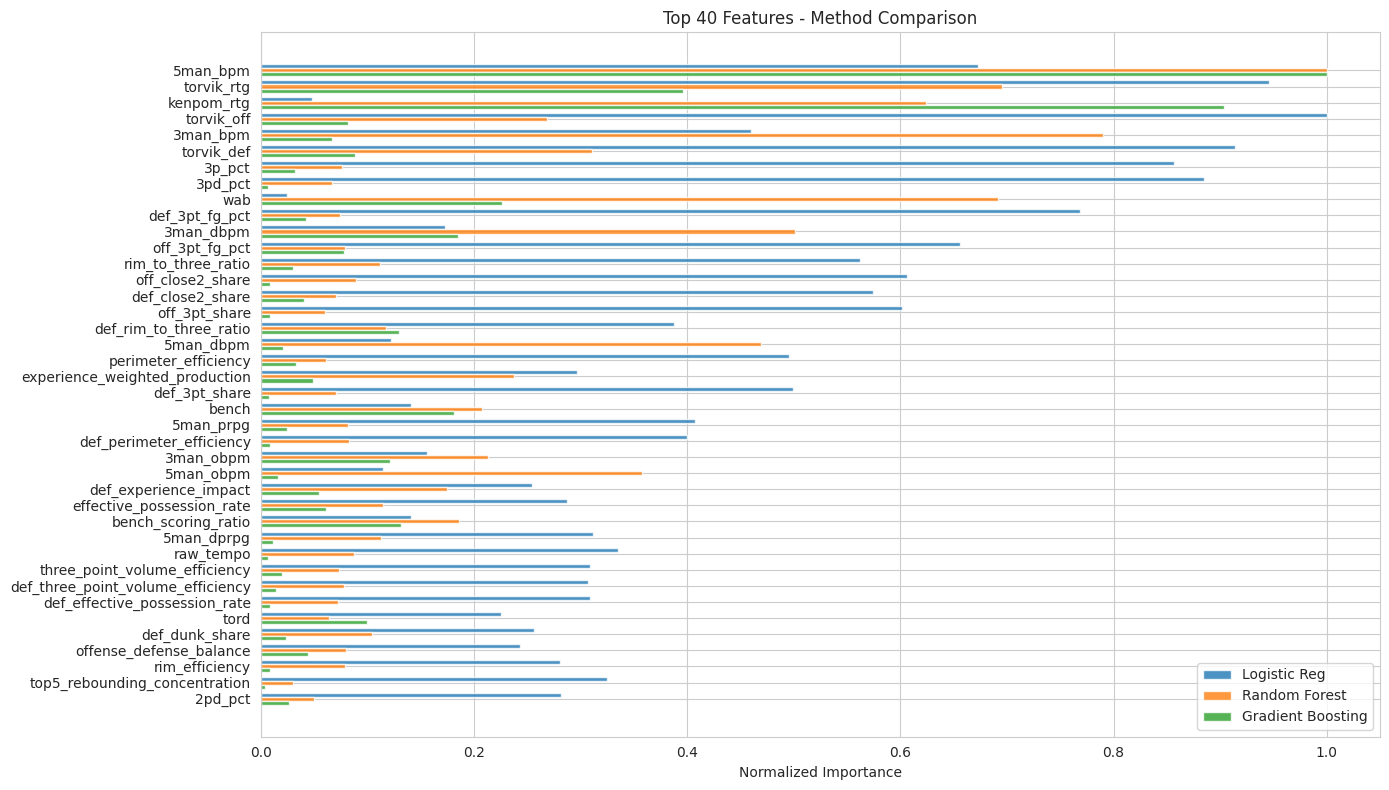

In [142]:
def plot_method_comparison(comparison, top_n=15):
    """
    Plot comparison of feature importance across methods
    """
    top_features = comparison.head(top_n)

    x = np.arange(len(top_features))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 8))

    ax.barh(x - width, top_features['lr_coef_norm'], width, label='Logistic Reg', alpha=0.8)
    ax.barh(x, top_features['rf_importance_norm'], width, label='Random Forest', alpha=0.8)
    ax.barh(x + width, top_features['gb_importance_norm'], width, label='Gradient Boosting', alpha=0.8)

    ax.set_yticks(x)
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Top {top_n} Features - Method Comparison')
    ax.legend()
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_method_comparison(comparison, top_n=40)

In [143]:
# =============================================================================
# 8. DECISION TREE FOR INTERPRETABILITY
# =============================================================================

def simple_decision_tree(max_depth=3):
    """
    Fit a shallow decision tree for interpretability
    """
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)

    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': dt.feature_importances_
    }).sort_values('importance', ascending=False)

    # Filter to features actually used
    used_features = importance_df[importance_df['importance'] > 0]

    print(f"\nDecision Tree (max_depth={max_depth})")
    print(f"Features used: {len(used_features)}")
    print(f"Train score: {dt.score(X_train, y_train):.4f}")
    print(f"Test score: {dt.score(X_test, y_test):.4f}")
    print("\nFeatures used:")
    print(used_features)

    return importance_df, dt

dt_importance, dt_model = simple_decision_tree(max_depth=5)


Decision Tree (max_depth=5)
Features used: 22
Train score: 0.8096
Test score: 0.6454

Features used:
                            feature  importance
3                        kenpom_rtg    0.564208
0                          5man_bpm    0.092734
12                            bench    0.036741
51                             tord    0.035000
74                 rotation_balance    0.033909
82   experience_weighted_production    0.027047
96           def_rim_to_three_ratio    0.024422
19                   off_far2_share    0.023008
79            assist_to_usage_ratio    0.018732
17                   off_dunk_share    0.016582
52                          drb_pct    0.016206
105           def_experience_impact    0.013670
9                              size    0.013521
33                              ftr    0.012655
42                        5man_dbpm    0.012655
77      offensive_versatility_score    0.011249
11                       experience    0.009374
37                          blk_pc